## Mapping the environmental signatures of New York City’s neigborhoods


#### This notebook is a companion for the Moonchild project. It contains a number of sample analysis performed on data obtained with the Moonchild Mobile Sensing System

In [1]:
# Standard imports to work with data, graphs, APIs, etc.

# Compatibility with Python 3
from __future__ import print_function, division

import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO
# from get_jsonparsed_data import get_jsonparsed_data
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.interpolate import *
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import zipfile
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    
from IPython.display import Image
from IPython.core.display import HTML

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
#update the rcParams object
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['griddata', 'insert', 'polyint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Aditional Imports
import pyowm
import calendar
import json
import pickle
from datetime import date, timedelta
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import time

In [3]:
# Helper function to query CartoDB using the SQL API
# Function from fedhere reference notebook
# https://github.com/fedhere/PUI2016_fb55/blob/master/HW12_fb55/Assignment%201%20instructions.ipynb

def queryCartoDB(query, format, source):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
# Get the complete moonchild dataset 
# We will filter specific deployments later

SQL_SOURCE = 'https://sbg389.carto.com:443/api/v2/sql'

NYCshapeQuery = '''
SELECT *
FROM moonchild
'''
#where cartodb_id > 209 and cartodb_id < 269

NYCshapeStream = queryCartoDB(NYCshapeQuery, format = 'GeoJSON',source=SQL_SOURCE)
NYCshapeData = json.loads(NYCshapeStream.read())
GDFMoonchild = gpd.GeoDataFrame.from_features(NYCshapeData['features'])

GDFMoonchild.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYCshape.to_crs(epsg = 2263, inplace = True) # from ft2 to mi2 

#GDFMoonchild['geometry'] = GDFMoonchild['geometry'].map(lambda x: (Point(x.y,x.x)))

In [5]:
# Persist the dataset
#with open('data/moonchildGTrain.geojson', 'w') as f:
#    f.write(GDFMoonchild.to_json())

In [6]:
#plutoLIC.geojson

# Load the geojson file with the zip codes into a geodataframe
#geoLIC = GeoDataFrame.from_file('data/plutoBetaDeployment.geojson')

#GDFMoonchild = GeoDataFrame.from_file('data/moonchildGTrain.geojson')
geoMonnchildPlutoMNH = GeoDataFrame.from_file('data/plutoMidtown.geojson')
geoMoonchildPlutoQNS = GeoDataFrame.from_file('data/plutoQueens.geojson')


# Get the different deployments based on their IDs
GDFMoonchildMidtown = GDFMoonchild[( GDFMoonchild.cartodb_id > 341) & 
                               (GDFMoonchild.cartodb_id < 393)]

GDFMoonchildLowerEast = GDFMoonchild[( GDFMoonchild.cartodb_id > 394) & 
                               (GDFMoonchild.cartodb_id < 424)]

GDFMoonchildLIC = GDFMoonchild[( GDFMoonchild.cartodb_id > 423) & 
                               (GDFMoonchild.cartodb_id < 461)]

GDFMoonchildAstoria = GDFMoonchild[( GDFMoonchild.cartodb_id > 460) & 
                               (GDFMoonchild.cartodb_id < 479)]

GDFMoonchildHells = GDFMoonchild[( GDFMoonchild.cartodb_id > 486) & 
                               (GDFMoonchild.cartodb_id < 505)]

GDFMoonchildHellsTwo = GDFMoonchild[( GDFMoonchild.cartodb_id > 505) & 
                               (GDFMoonchild.cartodb_id < 516)]

In [7]:
# Append Datasets to plot agregated deployments
GDFMoonchildQNS = GDFMoonchildLIC.append(GDFMoonchildAstoria, ignore_index=True)
GDFMoonchildMidtown = GDFMoonchildMidtown.append(GDFMoonchildHells, ignore_index=True)
GDFMoonchildMidtown = GDFMoonchildMidtown.append(GDFMoonchildHellsTwo, ignore_index=True)

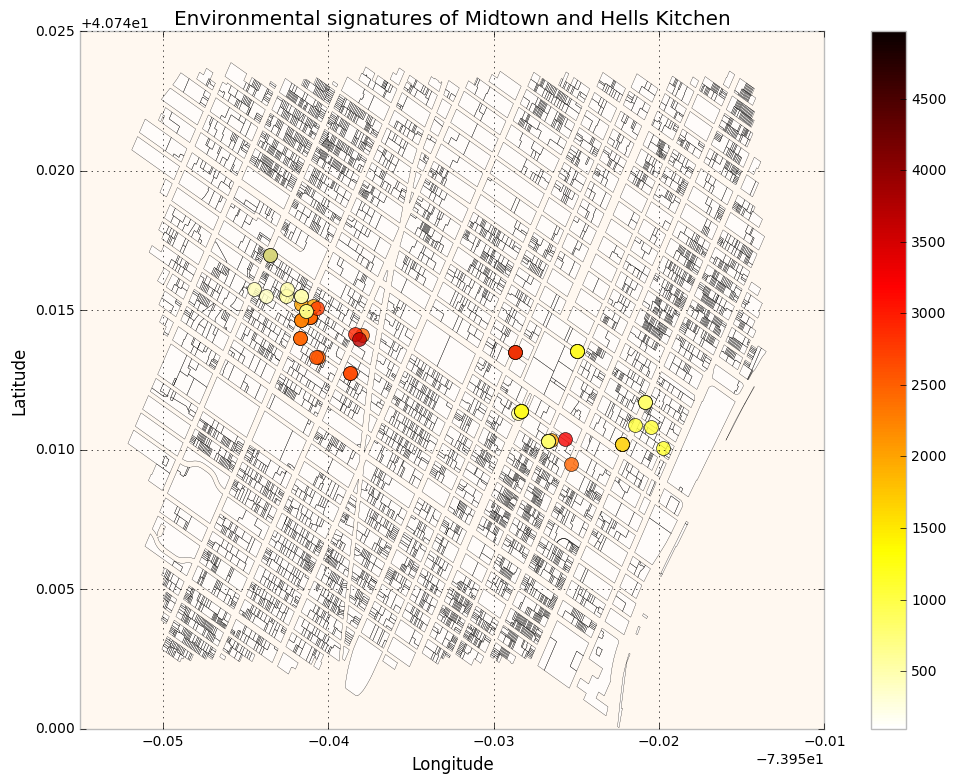

In [53]:
# Mapping the Midtown and Hells Kitchen Locations
# The colormap is based in SPC

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(12,9))

geoMonnchildPlutoMNH.plot(alpha=0.7,linewidth=0.2, ax=ax1, color='white')
GDFMoonchildMidtown.plot(column='spc', cmap='hot_r', marker='o', markersize=10,
                  linewidth = 4, alpha=0.8, ax = ax1)

ax1.set_title('Environmental signatures of Midtown and Hell''s Kitchen')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=GDFMoonchildMidtown.spc.min(),
                              vmax=GDFMoonchildMidtown.spc.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(GDFMoonchildMidtown.spc)
pl.colorbar(scalarmappaple, ax=ax1)

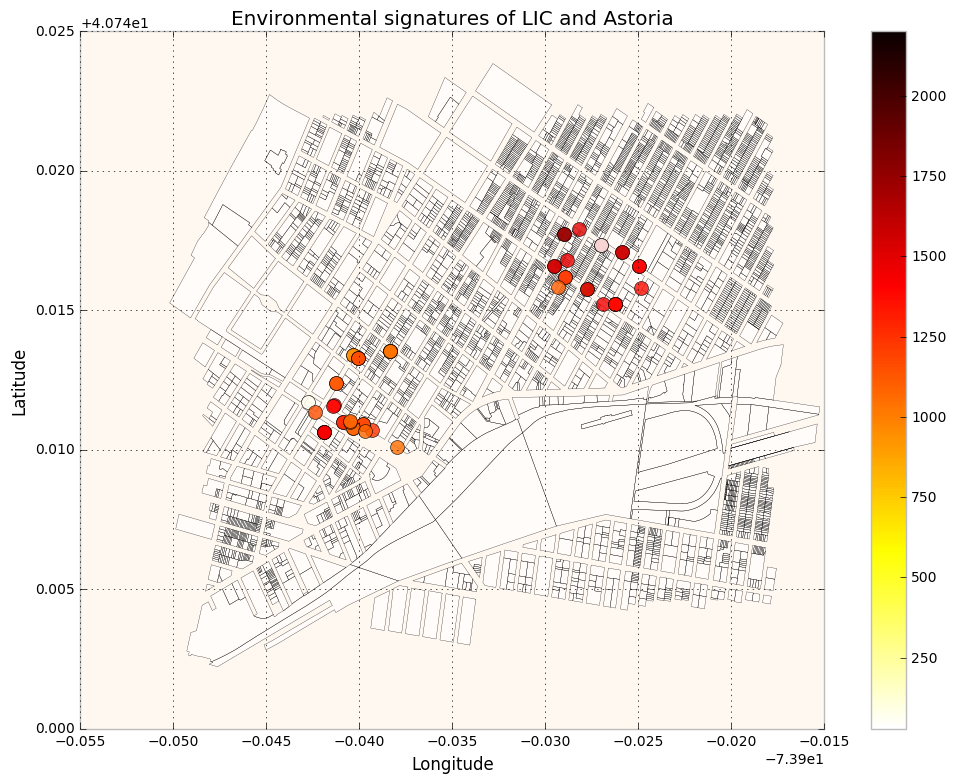

In [10]:
# Mapping the LIC and Astoria
# The colormap is based in SPC

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(12,9))

geoMoonchildPlutoQNS.plot(alpha=0.7,linewidth=0.2, ax=ax1, color='white')
GDFMoonchildQNS.plot(column='spc', cmap='hot_r', marker='o', markersize=10,
                  linewidth = 4, alpha=0.8, ax = ax1)

ax1.set_title('Environmental signatures of LIC and Astoria')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=GDFMoonchildQNS.spc.min(),
                              vmax=GDFMoonchildQNS.spc.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(GDFMoonchildQNS.spc)
pl.colorbar(scalarmappaple, ax=ax1)

In [11]:
GDFMoonchildClustering = GDFMoonchild[( GDFMoonchild.cartodb_id > 341)]

In [12]:
# Will use the K-Means Clustering algorithm to cluster the urban areas
# K-Means uses Eucledian Distance, and we will be using all four features 
# (we will not do PCA to reduce them to a two dimensional space)

# Preparing the data for K-Means: Whitening
# Whitening rescales each feature dimension of the observation by
# dividing it by its standard deviation across all observations to give it unit variance.

# We only want to Whiten the air quality related features columns!

whiten_columns = ['lpc', 'spc','netatmoco2']

GDFMoonchildClustering = GDFMoonchildClustering.copy()

# Whiten data.
GDFMoonchildClustering.loc[:, whiten_columns] = \
GDFMoonchildClustering[whiten_columns].apply(lambda col: col / col.std())


In [13]:
GDFMoonchildClustering.head()

,cartodb_id,geometry,lpc,netatmoco2,netatmohumidity,netatmonoise,netatmotemp,spc,tag,time_stamp
0,534,POINT (-73.939886 40.751399),0.232367,2.490093,43.0,54.0,23.0,0.132212,Moonchild,2017-05-07T22:48:22Z
1,535,POINT (-73.939886 40.751399),0.184140,2.490093,43.0,54.0,23.0,0.128393,Moonchild,2017-05-07T22:49:21Z
2,536,POINT (-73.939886 40.751399),0.236751,2.222843,42.0,56.0,23.3,0.125529,Moonchild,2017-05-07T22:50:20Z
3,537,POINT (-73.939886 40.751399),0.254288,2.222843,42.0,56.0,23.3,0.127916,Moonchild,2017-05-07T22:51:19Z
4,538,POINT (-73.939886 40.751399),0.236751,2.553724,42.0,56.0,23.6,0.134121,Moonchild,2017-05-07T22:52:18Z


In [15]:
GDFMoonchildClustering.index = GDFMoonchildClustering['cartodb_id']
GDFMoonchildClustering = GDFMoonchildClustering[['lpc', 'spc',\
                                         'netatmoco2']]

In [19]:
# K-Means Clustering for 2000

kmeans = KMeans(n_clusters=5, random_state=170)
clusters = kmeans.fit(GDFMoonchildClustering)

GDFMoonchildClustering['cluster'] = pd.Series(clusters.labels_, index=GDFMoonchildClustering.index)
GDFMoonchildClustering.head()

,lpc,spc,netatmoco2,cluster
cartodb_id,,,,
534,0.232367,0.132212,2.490093,0
535,0.184140,0.128393,2.490093,0
536,0.236751,0.125529,2.222843,0
537,0.254288,0.127916,2.222843,0
538,0.236751,0.134121,2.553724,0


In [20]:
GDFMoonchildClustering['cartodb_id'] = GDFMoonchildClustering.index
GDFMoonchildClustering = GDFMoonchildClustering[['cartodb_id', 'cluster']]

In [24]:
GDFMoonchild = pd.merge(GDFMoonchild, GDFMoonchildClustering,on='cartodb_id')  

In [26]:
GDFMoonchild.head()

,cartodb_id,geometry,lpc,netatmoco2,netatmohumidity,netatmonoise,netatmotemp,spc,tag,time_stamp,cluster
0,534,POINT (-73.939886 40.751399),53,587.0,43.0,54.0,23.0,277,Moonchild,2017-05-07T22:48:22Z,0
1,535,POINT (-73.939886 40.751399),42,587.0,43.0,54.0,23.0,269,Moonchild,2017-05-07T22:49:21Z,0
2,536,POINT (-73.939886 40.751399),54,524.0,42.0,56.0,23.3,263,Moonchild,2017-05-07T22:50:20Z,0
3,537,POINT (-73.939886 40.751399),58,524.0,42.0,56.0,23.3,268,Moonchild,2017-05-07T22:51:19Z,0
4,538,POINT (-73.939886 40.751399),54,602.0,42.0,56.0,23.6,281,Moonchild,2017-05-07T22:52:18Z,0


In [27]:
# Get the different deployments based on their IDs
GDFMoonchildMidtown = GDFMoonchild[( GDFMoonchild.cartodb_id > 341) & 
                               (GDFMoonchild.cartodb_id < 393)]

GDFMoonchildLowerEast = GDFMoonchild[( GDFMoonchild.cartodb_id > 394) & 
                               (GDFMoonchild.cartodb_id < 424)]

GDFMoonchildLIC = GDFMoonchild[( GDFMoonchild.cartodb_id > 423) & 
                               (GDFMoonchild.cartodb_id < 461)]

GDFMoonchildAstoria = GDFMoonchild[( GDFMoonchild.cartodb_id > 460) & 
                               (GDFMoonchild.cartodb_id < 479)]

GDFMoonchildHells = GDFMoonchild[( GDFMoonchild.cartodb_id > 486) & 
                               (GDFMoonchild.cartodb_id < 505)]

GDFMoonchildHellsTwo = GDFMoonchild[( GDFMoonchild.cartodb_id > 505) & 
                               (GDFMoonchild.cartodb_id < 516)]

In [28]:
# Append Datasets to plot agregated deployments
GDFMoonchildQNS = GDFMoonchildLIC.append(GDFMoonchildAstoria, ignore_index=True)
GDFMoonchildMidtown = GDFMoonchildMidtown.append(GDFMoonchildHells, ignore_index=True)
GDFMoonchildMidtown = GDFMoonchildMidtown.append(GDFMoonchildHellsTwo, ignore_index=True)

In [39]:
# Create a dictionary with the land uses:

dfLandUse = pd.DataFrame(columns=["landuse", "landusedescription"])
dfLandUse.loc[0] = ["01","One &Two Family Buildings"]
dfLandUse.loc[1] = ["02","Multi-Family Walk-Up Buildings"]
dfLandUse.loc[2] = ["03","Multi-Family Elevator Buildings"]
dfLandUse.loc[3] = ["04","Mixed Residential & Commercial Buildings"]
dfLandUse.loc[4] = ["05","Commercial & Office Buildings"]
dfLandUse.loc[5] = ["06","Idustrial & Manufacturing"]
dfLandUse.loc[6] = ["07","Transportation & Utility"]
dfLandUse.loc[7] = ["08","Public Facilities & Institutions"]
dfLandUse.loc[8] = ["09","Open Space & Outdoor Recreation"]
dfLandUse.loc[9] = ["10","Parking Facilities"]
dfLandUse.loc[10] = ["11","Vacant Land"]

dfLandUse


,landuse,landusedescription
0,01,One &Two Family Buildings
1,02,Multi-Family Walk-Up Buildings
2,03,Multi-Family Elevator Buildings
3,04,Mixed Residential & Commercial Buildings
4,05,Commercial & Office Buildings
5,06,Idustrial & Manufacturing
6,07,Transportation & Utility
7,08,Public Facilities & Institutions
8,09,Open Space & Outdoor Recreation
9,10,Parking Facilities


In [40]:
geoMonnchildPlutoMNH = pd.merge(geoMonnchildPlutoMNH,
                                    dfLandUse, on='landuse')

In [44]:
GDFMoonchildQNS.head()

,cartodb_id,geometry,lpc,netatmoco2,netatmohumidity,netatmonoise,netatmotemp,spc,tag,time_stamp,cluster
0,424,POINT (-73.94089 40.750976),235,320.0,49.0,73.0,22.8,1284,Moonchild,2017-05-06T11:40:29Z,2
1,425,POINT (-73.94089 40.750976),239,320.0,49.0,73.0,22.8,1287,Moonchild,2017-05-06T11:41:27Z,2
2,426,POINT (-73.94191600000001 40.750614),267,320.0,49.0,73.0,22.8,1307,Moonchild,2017-05-06T11:42:26Z,2
3,427,POINT (-73.94191600000001 40.750614),284,320.0,49.0,73.0,22.8,1374,Moonchild,2017-05-06T11:43:25Z,2
4,428,POINT (-73.94191600000001 40.750614),288,320.0,49.0,73.0,22.8,1508,Moonchild,2017-05-06T11:44:25Z,2


In [45]:
geoMoonchildPlutoQNS = pd.merge(geoMoonchildPlutoQNS,
                                    dfLandUse, on='landuse')

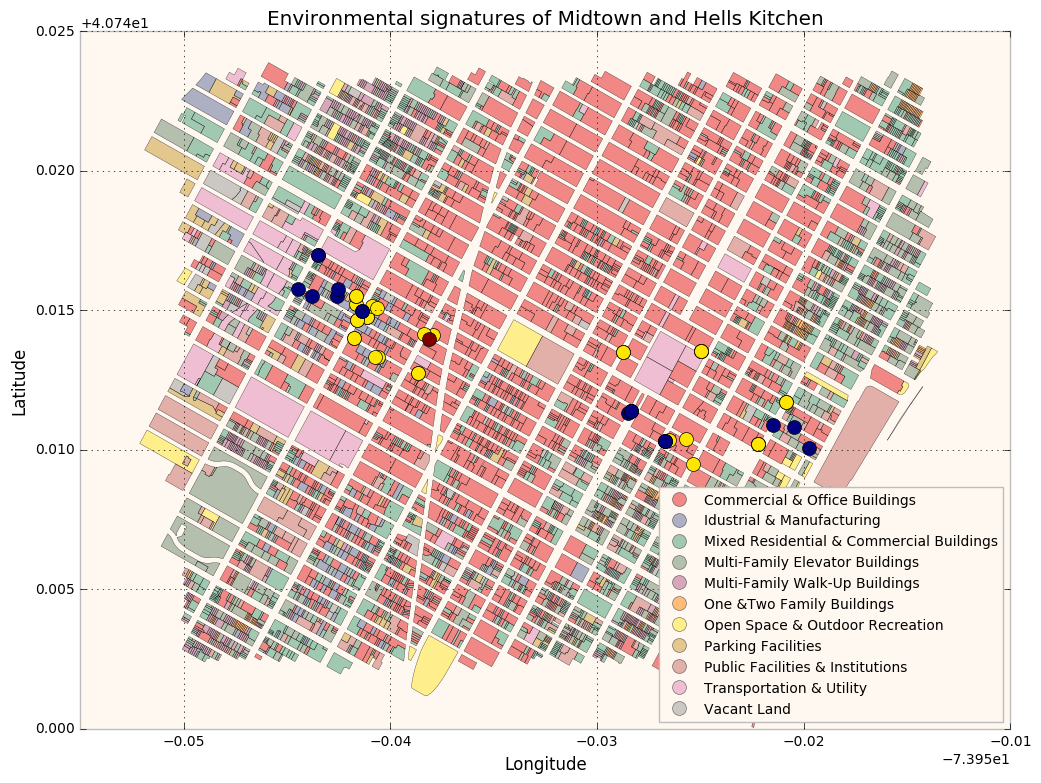

In [42]:
# Mapping the Midtown and Hells Kitchen Locations
# The colormap is based in SPC

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(12,9))

geoMonnchildPlutoMNH.plot(column='landusedescription', alpha=0.5,linewidth=0.2,
                          ax=ax1, legend=True)
GDFMoonchildMidtown.plot(column='cluster', marker='o', markersize=10,
                  linewidth = 4, alpha=1, ax = ax1)

ax1.set_title('Environmental signatures of Midtown and Hell''s Kitchen')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

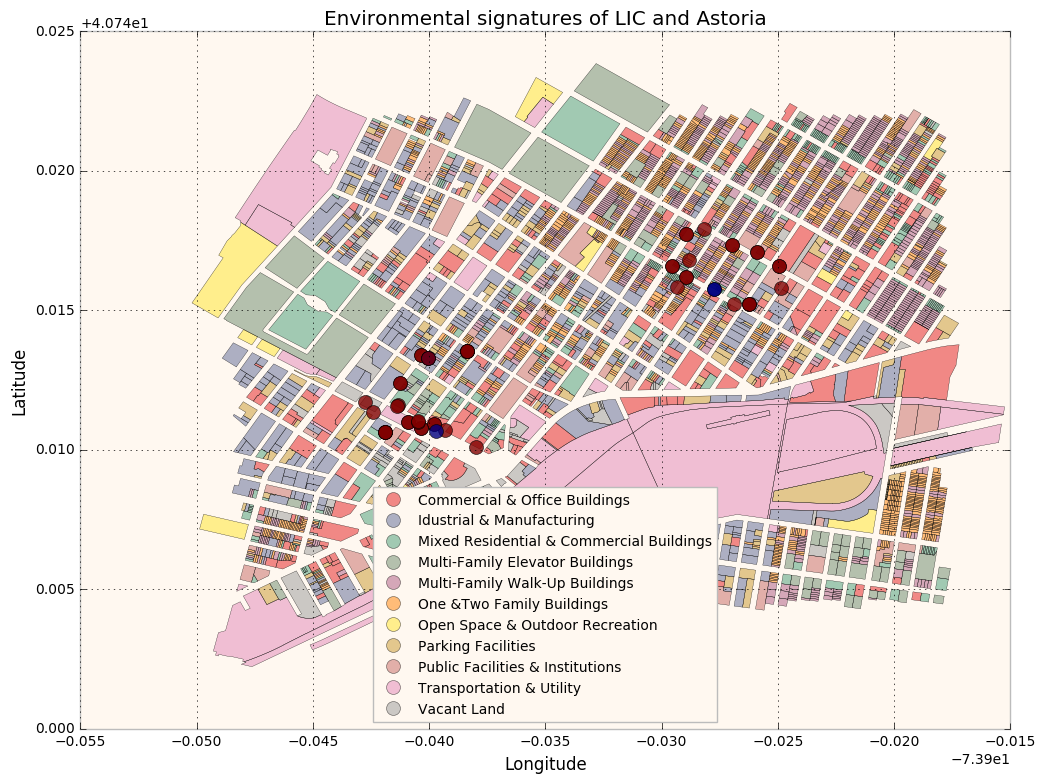

In [47]:
# Mapping the LIC and Astoria
# The colormap is based in SPC

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(12,9))

geoMoonchildPlutoQNS.plot(column='landusedescription', alpha=0.5,linewidth=0.2,
                          ax=ax1, legend=True)
GDFMoonchildQNS.plot(column='cluster', marker='o', markersize=10,
                  linewidth = 4, alpha=0.8, ax = ax1)

ax1.set_title('Environmental signatures of LIC and Astoria')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')